# Introduction
Having access to quality checked data at the push of a button is just one piece of the puzzle. That capability alone doesn't necessarily translate to impactful water risk assessment, but it does provide the foundation for it. Divirod uses the millions of records available in the data lake to establish a "normal" range of water level for each location derived from historical measurements. This process of defining 'normal' ranges enables the identification of anomalies, such as sudden spikes or dips in water levels, abnormal flow rates, or unexpected weather patterns. 

# Goal
The goal of this notebook is to demonstrate how the data in Divirod's data lake can be used to calculate thresholds for abnormal water level conditions. The workflow outlined in this notebook is currently implemented by Divirod, and is just one of many possible workflows that customers can build using Divirod's data platform. Customers can either access this dataset directly from Divirod or define customized workflows in a similar manner more tailored to their specifically defined risk thresholds.

This notebook will contain a combination of detailed code for execution of this process, as well as explanatory text intermingled throughout.

The below graphic serves as a reference to where the content within this notebook sits in relation to Divirod's overall data ingestion pipeline. 


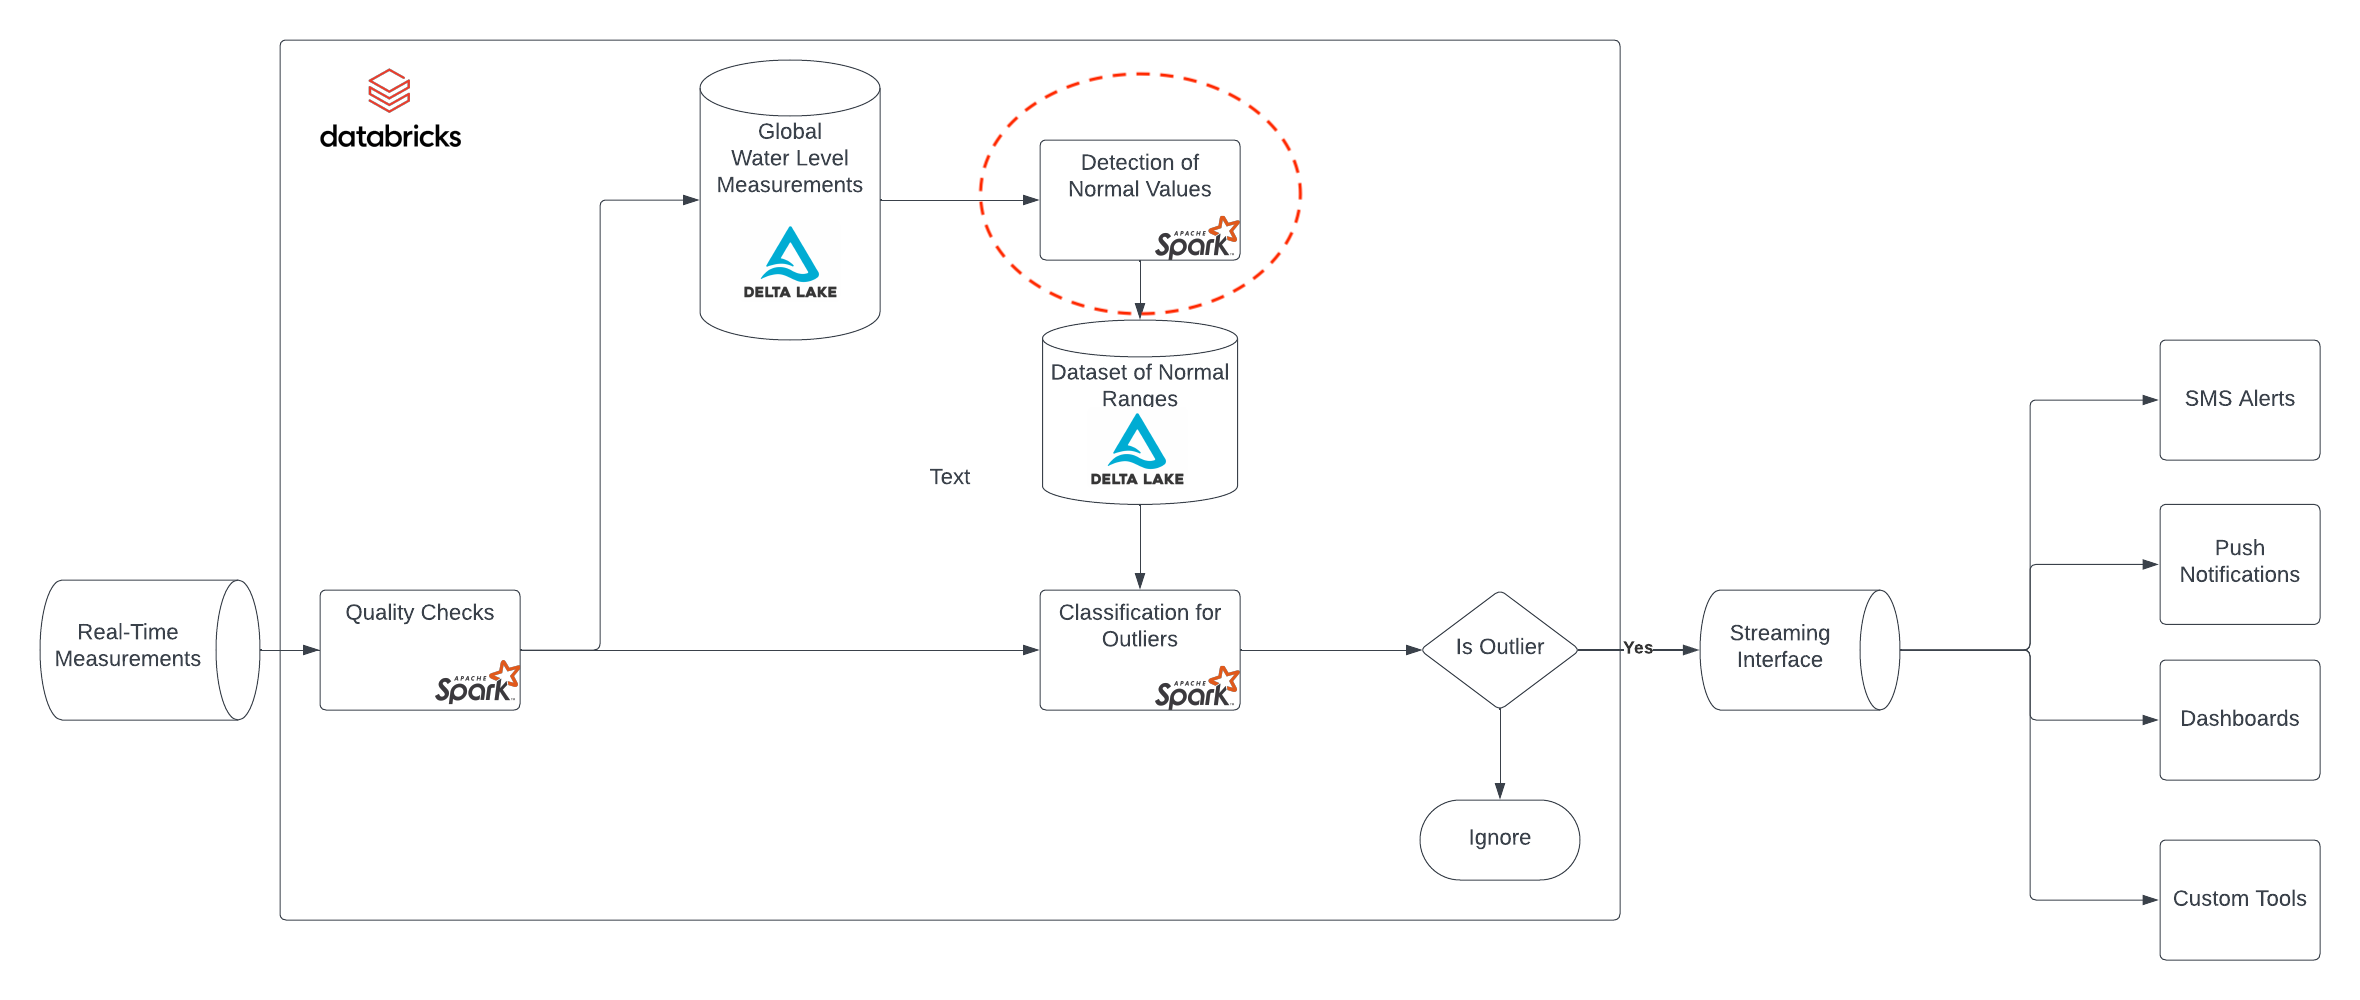

In [3]:
import base64
from IPython.display import HTML

image_path = './../images/architecture_diagram_detect_normal_vals.png'

# Function to get Base64 string of an image
def get_image_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_base64 = get_image_base64(image_path)

# Create an HTML string with the Base64 embedded and width set to 100%
html = f'<img src="data:image/jpg;base64,{image_base64}" style="width:100%;">'

# Display the image in the notebook
display(HTML(html))

# Example Workflow Explanation

## Calculate Water Risk Thresholds
This process is meant to showcase how users can apply their own workflows on top of the Divirod data lake. This example is taken from the workflow used to define the 'normal' and 'extreme' conditions used as the foundation for [Divirod's Water Level Index (WLI)](https://wli.divirod.com/).

A few caveats:
* In reality, the defined thresholds based on *all* the data in the delta lake for a particular instrument. For the purposes of this demo however, thresholds will be calculated using only the 2022 data from billings in the provided parquet file.
* This is a static process - this calculation is not performed on streamed data, but on a static pull of ALL the data available for each instrument.
* The example threshold values are calculated for a riverine system, which displays different seasonal trends than coastal or reservoir systems. This example applies *only* to riverine systems. More details on how Divirod calculates water risk thresholds based on system dynamics can be found in the [WLI Methodology Documentation](https://wli.divirod.com/methodology.pdf).

### Water Level Status Classification Equations

Divirod has chosen to assign one of five water level status codes to each gauge in the data lake: ‘extremely high,’ ‘high,’ ‘normal,’ ‘low,’ and ‘extremely low.’ For all water body systems, these classifications are assigned based on the statistical distribution of all the data records for each gauge.

The equations for these classifications are given by:

$$ WL_e = \mu_{wl} \pm X_e \cdot \sigma_{wl} $$
$$ WL_{hl} = \mu_{wl} \pm X_{hl} \cdot \sigma_{wl} $$


Where:
* *WL<sub>e</sub>* = Extreme water level
* *X<sub>e</sub>* = Extreme multiplier $$
* *WL<sub>hl</sub>*= High/low water level 
* *X_<sub>hl</sub>* = High/low multiplier 
* *μ_<sub>wl</sub>* = Mean water level
* *σ_<sub>wl</sub>* = Standard deviation of recorded water levels 


### Classification for River Systems
River systems display a unique seasonal water level pattern. Heavily influenced by winter run off and
spring rainstorms, both river stage (water level) and flow rate tend to increase very rapidly in the
months coming out of winter, slowly tapering off later into the summer. Because of the unique system
characteristics of rivers and their relationship to spring runoff, the annual water levels for a specific river
location generally do not follow a normal distribution. An analysis of all records associated with river
systems in our data lake indicated that the data is heavily right skewed. To account for this, the water
level readings for river systems were transformed by taking their natural log before applying the
statistical method described above. While not always a perfect fit, this transformation brought the
series much closer to a normal distribution. After the extreme and high/low thresholds are calculated in
the log space, they are transformed back into the original units before each record is assigned a status. The below two charts demonstrate the data from our selected example location before and after the log transform is applied. 


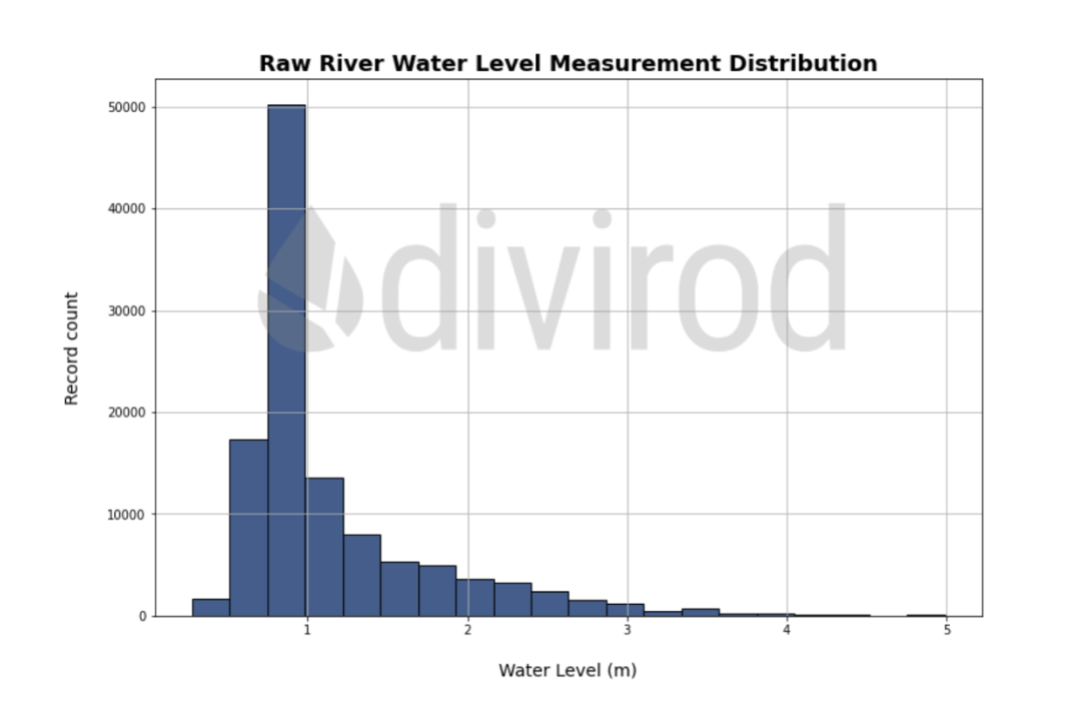

In [4]:
import base64
from IPython.display import HTML

image_path = './../images/river_right_skewed_data_ex.png'

# Function to get Base64 string of an image
def get_image_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_base64 = get_image_base64(image_path)


html = f'<img src="data:image/jpg;base64,{image_base64}" style="width:60%; height: auto; display: block; margin: auto;">'


# Display the image in the notebook
display(HTML(html))


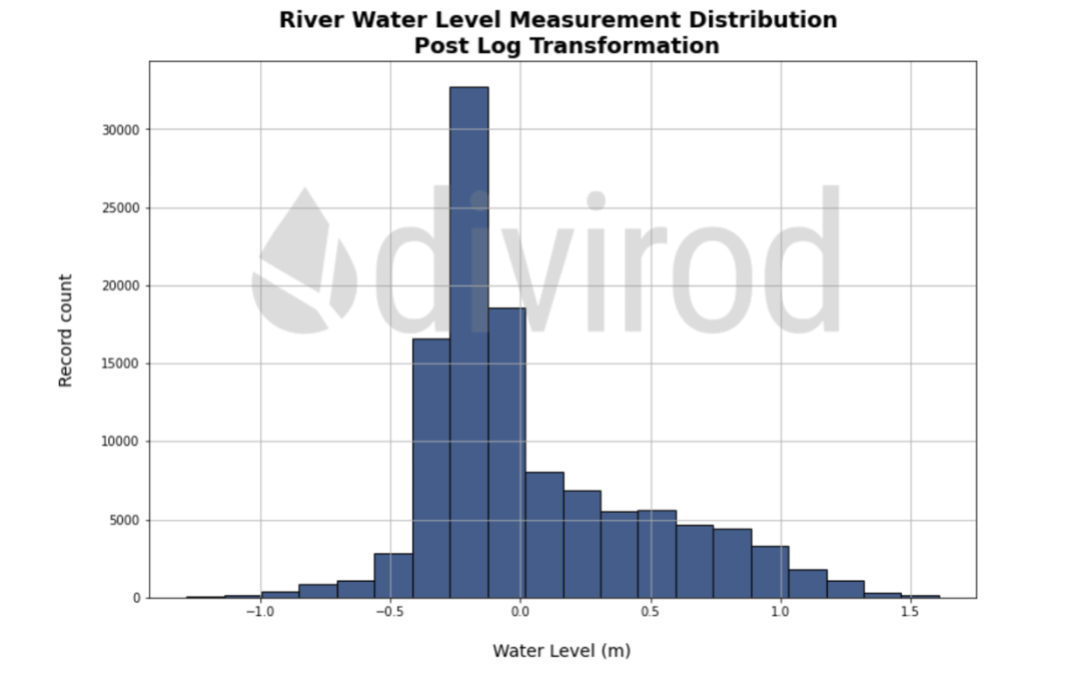

In [5]:
import base64
from IPython.display import HTML

image_path = './../images/river_normalized_data_ex.png'

# Function to get Base64 string of an image
def get_image_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_base64 = get_image_base64(image_path)


html = f'<img src="data:image/jpg;base64,{image_base64}" style="width:60%; height: auto; display: block; margin: auto;">'


# Display the image in the notebook
display(HTML(html))

The selected extreme multiplier for river systems is a value of 3, meaning that anything greater than 3
standard deviations away from the mean in the log space is classified as an “extreme condition”. The
high/low multiplier for river systems is a value of 2, meaning any value within 2 standard deviations of
the mean are classified as a “normal condition”. The below Figure illustrates this classification for a river
gauge on the Yellowstone River at Billings Montana (USGS: 06214500).


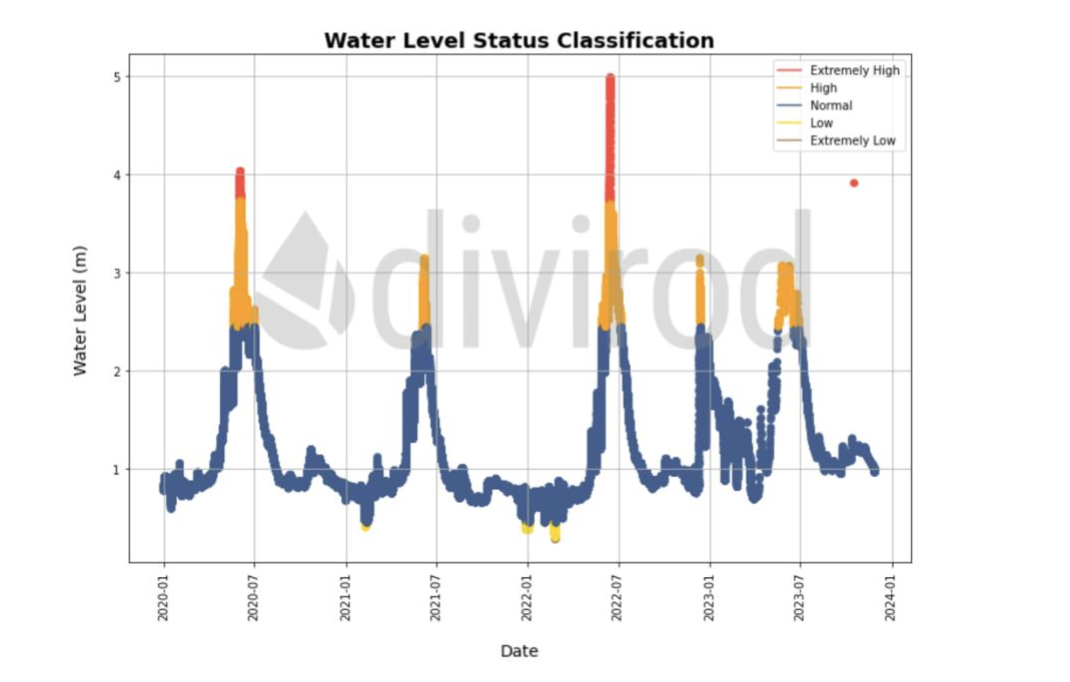

In [6]:
import base64
from IPython.display import HTML

image_path = './../images/river_classification_ex.png'

# Function to get Base64 string of an image
def get_image_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_base64 = get_image_base64(image_path)


html = f'<img src="data:image/jpg;base64,{image_base64}" style="width:60%; height: auto; display: block; margin: auto;">'


# Display the image in the notebook
display(HTML(html))

The below code section demonstrates the implementation of this workflow. Customers with access to the Divirod data lake can perform similar threshold calculations or utilized Divirod's pre-defined thresholds. 

# Code Example

## Initialization

### Imports

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession


import pandas as pd
import numpy as np
import datetime


# for typing
from pyspark.sql import dataframe as sparkDataFrame

### Load Data

In [ ]:
# this file path will be updated to the appropriate path in the github repo
quality_checked_fp = "./../data/billings_11074_all_measurements_2022_with_dq"

In [ ]:
billings_data_all = spark.read.parquet(quality_checked_fp)

In [ ]:
# see 'Example Workflow Explanation' section for the reasoning behind the choice of these multipliers
river_extreme_multiplier = 3
river_high_low_multiplier = 2

### Calculate Thresholds

In [ ]:
# take the log of the height to transform to a normal distribution
billings_data_all = billings_data_all.withColumn("log_height_native", F.log(F.col("height_native")))

# normally, this calculation is applied for all instruments in the data (applied across the entire data lake)
# for this example, we will only calculate these values for the Billings location
mean_log_height = billings_data_all.agg(F.mean("log_height_native").alias("mean_log_height_native")).collect()[0]["mean_log_height_native"]
std_log_height = billings_data_all.agg(F.stddev("log_height_native").alias("stddev_log_height_native")).collect()[0]["stddev_log_height_native"]

# compute thresholds for each instrument in the log space
extreme_high_threshold = round(mean_log_height + river_extreme_multiplier * std_log_height, 3)
high_threshold = round(mean_log_height + river_high_low_multiplier * std_log_height, 3)
low_threshold = round(mean_log_height - river_extreme_multiplier * std_log_height, 3)
extreme_low_threshold = round(mean_log_height - river_high_low_multiplier * std_log_height, 3)

### Save Thresholds
In reality, these thresholds will be stored in a delta lake table, joined with the underlying data set, or a similar workflow to tie these thresholds to each instrument in the delta lake to be referenced later in the water risk assessment workflow (see Solution Accelerator Part 3). For this demo, a simple CSV export will suffice.

In [ ]:

threshold_data = {
    "instrument_id": [11074], # instrument id for our example dataset
    "extreme_high_threshold": [extreme_high_threshold],
    "high_threshold": [high_threshold],
    "low_threshold": [low_threshold],
    "extreme_low_threshold": [extreme_low_threshold]
}

# Create a pandas DataFrame for expport
threshold_df = pd.DataFrame(threshold_data)



In [ ]:
# this has already been exported as a CSV file that can be pulled into the last notebook in this accelerator
threshold_df

,instrument_id,extreme_high_threshold,high_threshold,low_threshold,extreme_low_threshold
0,11074,1.495,1.009,-1.423,-0.937
